In [36]:
from keras.applications import VGG16
import os,sys
import numpy as np
import pandas
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras import optimizers
import time
import glob
import cv2

In [2]:
folder = os.listdir("./data/SDNET2018/D")
image_size = 50
dense_size = len(folder)

X = []
Y = []
for index, name in enumerate(folder):
    dir = "./data/SDNET2018/D/" + name
    files = glob.glob(dir + "/*.jpg")
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        X.append(data)
        Y.append(index)
X = np.array(X)
Y = np.array(Y)
X = X.astype('float32')
X = X / 255.0


Y = np_utils.to_categorical(Y, dense_size)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

batch_size = 64
nb_epoch = 100

In [3]:
#VGG16のロード。FC層は不要なので　include_top=False
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(image_size,image_size,3))

#FC層の作成
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(dense_size, activation='softmax'))

#VGG16とFC層を結合してモデルを作成
vgg_model = Model(input=vgg16.input, output=top_model(vgg16.output))

#最後のconv層の直前までの層をfreeze
for layer in vgg_model.layers[:15]:
        layer.trainable = False
        
#多クラス分類を指定
vgg_model.compile(loss='categorical_crossentropy',
        optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
        metrics=['accuracy'])

c:\anaconda3\envs\rebuild_keras\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  if sys.path[0] == '':


In [4]:
#EarlyStopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    verbose = 1)

#ModelCheckpoint
result_dir = './result_dir/'
if os.path.exists(result_dir)==False:os.mkdir(result_dir)
model_checkpoint = ModelCheckpoint(
    result_dir + "val_loss[val_loss:.3f].hd5f",
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    period = 3)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 3,
    verbose = 1
)

#log for TensorBoard
log_dir = './log_dir/'
if os.path.exists(log_dir)==False:os.mkdir(log_dir)
logging = TensorBoard(log_dir)

In [5]:
#Fine-tuning
hist = vgg_model.fit(
    X_train,y_train,
    verbose=1,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, logging]
    )


c:\anaconda3\envs\rebuild_keras\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 8716 samples, validate on 2180 samples
Epoch 1/100
8716/8716 [==============================] - 5s 537us/step - loss: 0.4148 - acc: 0.8483 - val_loss: 0.3577 - val_acc: 0.8725
Epoch 2/100
8716/8716 [==============================] - 3s 394us/step - loss: 0.3747 - acc: 0.8648 - val_loss: 0.3328 - val_acc: 0.8789
Epoch 3/100
8716/8716 [==============================] - 3s 392us/step - loss: 0.3666 - acc: 0.8686 - val_loss: 0.3280 - val_acc: 0.8876
Epoch 4/100
8716/8716 [==============================] - 3s 392us/step - loss: 0.3547 - acc: 0.8743 - val_loss: 0.3170 - val_acc: 0.8894
Epoch 5/100
8716/8716 [==============================] - 3s 392us/step - loss: 0.3541 - acc: 0.8755 - val_loss: 0.3159 - val_acc: 0.8890
Epoch 6/100
8716/8716 [==============================] - 3s 393us/step - loss: 0.3431 - acc: 0.8807 - val_loss: 0.3089 - val_acc: 0.8881
Epoch 7/100
8716/8716 [==============================] - 3s 390us/step - loss: 0.3444 - acc: 0.8819 - val_loss: 0.3142 - val_acc: 

In [6]:
model_dir = './model/'
if os.path.exists(model_dir) == False:os.mkdir(model_dir)

vgg_model.save(model_dir + 'model.hdf5')

# optimizerのない軽量モデルを保存（学習や評価は不可だが、予測は可能）
vgg_model.save(model_dir + 'model-opt.hdf5', include_optimizer = False)

# ベストの重みのみ保存
weights_dir = './weights_dir/'
if os.path.exists(weights_dir) == False:os.mkdir(weights_dir)
vgg_model.save_weights(weights_dir + 'model_weight.hdf5')

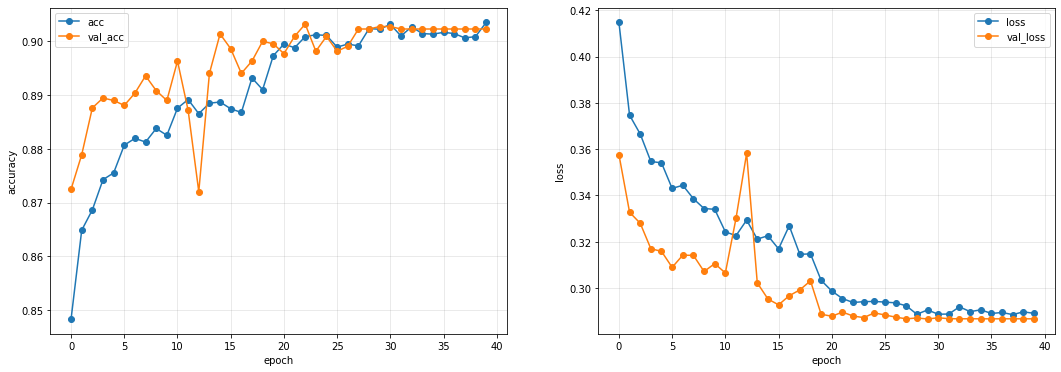

In [7]:
plt.figure(figsize = (18,6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history["acc"], label = "acc", marker = "o")
plt.plot(hist.history["val_acc"], label = "val_acc", marker = "o")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("accuracy")
#plt.title("")
plt.legend(loc = "best")
plt.grid(color = 'gray', alpha = 0.2)

# loss
plt.subplot(1, 2, 2)
plt.plot(hist.history["loss"], label = "loss", marker = "o")
plt.plot(hist.history["val_loss"], label = "val_loss", marker = "o")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.title("")
plt.legend(loc = "best")
plt.grid(color = 'gray', alpha = 0.2)

plt.show()

In [1]:
score = vgg_model.evaluate(X_test,y_test,verbose=1)
print("evaluate loss: {0[0]}".format(score))
print("evaluate acc: {0[1]}".format(score))

prex = vgg_model.predict(X_test)
wrong = []
w_index = []
for i in range(2724):
    yi = y_test[i:i+1]
    prei = prex[i:i+1]
    if prei.argmax() != yi.argmax():
        wrong.append(i)
        w_index.append(y_test[i])
        
print(wrong)
print(w_index)
print('wrong',len(wrong))

NameError: name 'vgg_model' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


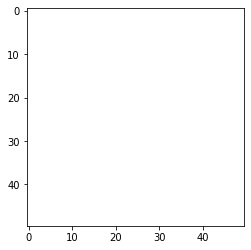

In [58]:
wrong_dir = './data/wrong/'
if os.path.exists(wrong_dir)==False:os.mkdir(wrong_dir)


im = (X[9]*255)
plt.imshow(im)
img = Image.fromarray(np.uint8(im))
img.save('./data/wrong/9.jpg')
    
for i in range(306):
    im = (X[wrong[i]]*255)
    img = Image.fromarray(np.uint8(im))
    img.save(wrong_dir + '{}.jpg'.format(i))

In [61]:
prex = vgg_model.predict(X[8])
print("evaluate loss: {0}".format(prex))
#print("evaluate acc: {0[1]}".format(prex))

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (50, 50, 3)